### ZNE with partial folding to obtain competitive expectation values for deep circuits

Zero Noise Extrapolation (ZNE) is an error mitigation technique used to obtain expectation values closer to the ideal noiseless value from a noisy quantum computer. ZNE can be classified broadly into three types - (i) analog ZNE, (ii) digital ZNE, and (iv) PEA ZNE. In this notebook we select digital ZNE primarily because it has a much simpler implementation than analog ZNE (Physical review letters, 119(18), 180509), and does not require the time consuming $learning$ step of PEA ZNE (Nature, 618(7965), 500-505).

The general idea of digital ZNE (dZNE) is to replace some gates $U$ by $U(U^{\dagger}U)^{\lambda}$ for some $\lambda \geq 1$. This ensures that the functionality of the circuit remains unchanged (since $U^{\dagger}U = I$), however, the noise is increased due to the increased number of gates. The expectation values are obtained for different values of $\lambda$, and then extrapolated to $\lambda = 0$ to obtain an estimate of the expectation value in zero noise limit.

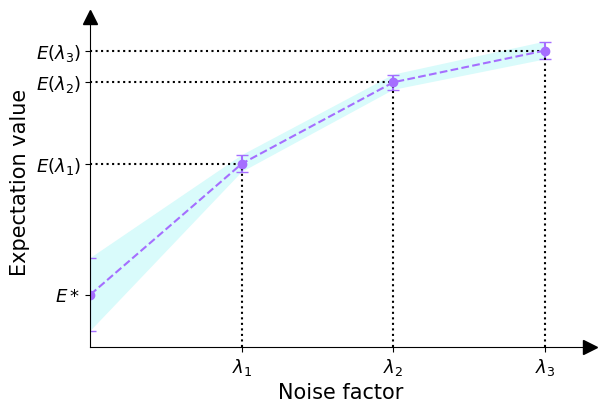

### Step 1: Map problem to quantum native format

In this notebook we shall consider a QAOA circuit as a use case. In particular, we consider the compute-uncompute version of the circuit. For any circuit, represented by the circuit unitary $U$, a compute-uncompute circuit appends $U^{-1}$ to it. This ensures that, in the noiseless scenario, the outcome of the circuit is $|0\rangle^{\otimes n}$ where $n$ is the number of qubits. Therefore, the ideal expectation value of any $Z$ type observable is $+1$. This method ensures that the ideal outcome is known without explicit simulation.

Note that in Qiskit the $U$ and $U^{-1}$ must be separated by a barrier so that the transpiler does not optimize the circuit to identity during execution.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy.random import default_rng
from numpy import pi

def build_compute_uncompute_qaoa_circuit(
    num_qubits: int,
    depth: int, # here the convention is depth=2*p
    ):
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    qaoa = QuantumCircuit(num_qubits)
    qaoa.compose(circuit, inplace=True)
    qaoa.barrier()
    qaoa.compose(circuit.inverse(), inplace=True)
    qaoa.measure_active()

    return qaoa

def produce_qaoa_parameters(num_layers, seed=None):
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()

    params = []
    for idx in range(len(betas)):
        params.append(gammas[idx])
        params.append(betas[idx])
    return params

Next, we show an example of a 30 qubits $p=5$ QAOA circuit

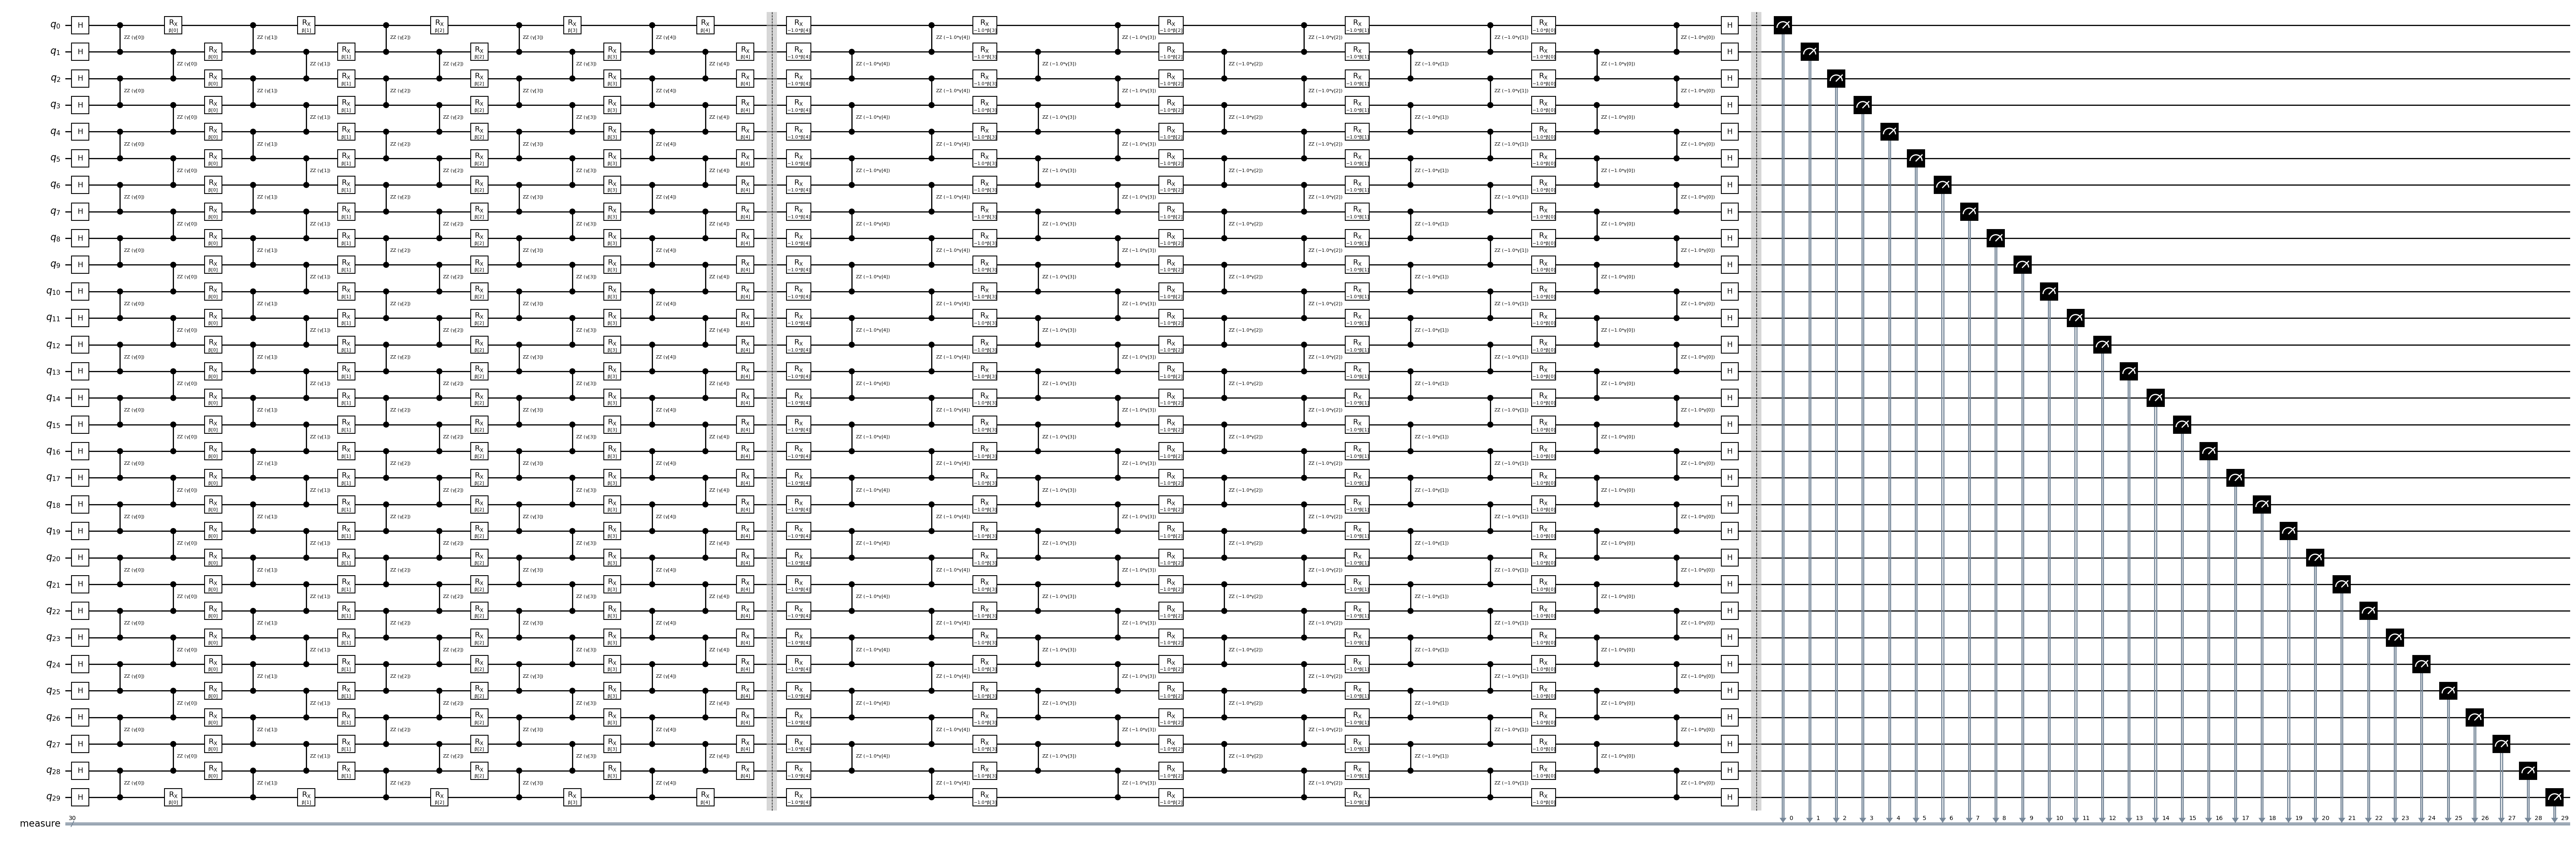

In [36]:
num_qubits = 30
p = 5
qaoa = build_compute_uncompute_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw', fold=-1)

### Step 2: Optimize circuits and observables

In ZNE, multiple circuits with different noise factors are executed. We shall transpile the original circuit at this stage so that all the folded circuits also remain transpiled, and we don't have to transpile each of them separately.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, EstimatorV2 as Estimator

In [24]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_pinguino1')
session = Session(backend=backend)

#### Transpile the circuit

In [37]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
trans_qaoa = pm.run(qaoa)

We note the 2-qubit depth of the transpiled circuit

In [38]:
trans_qaoa.depth(lambda x:x[0].num_qubits==2)

40

#### Expand observables to match the transpiled circuit layout

For this notebook the observable that we consider is the average of all weight-1 Z type observables.

In [39]:
from qiskit.quantum_info import SparsePauliOp

observable = ['I'*i + 'Z' + 'I'*(qaoa.num_qubits-i-1) for i in range(qaoa.num_qubits)]
observable = SparsePauliOp(observable, coeffs=[1/qaoa.num_qubits]*len(observable))
observable

SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI',

Note that this is a 30 qubit observable. However, after transpilation, the circuit is now expanded to the number of qubits in the hardware by appending ancilla qubits. Moreover, we note from the above transpiled circuit, that when the virtual circuit qubits have been placed on physical hardware qubits, the ordering of the qubits have changed. Our observable should conform to this layout of the qubits post transpilation.

In [40]:
final_layout = trans_qaoa.layout.final_index_layout()
final_layout

[68,
 67,
 66,
 73,
 85,
 86,
 87,
 93,
 106,
 105,
 104,
 103,
 102,
 101,
 100,
 110,
 118,
 117,
 116,
 115,
 114,
 109,
 96,
 95,
 94,
 90,
 75,
 76,
 77,
 78]

In [41]:
trans_obs = observable.apply_layout(final_layout, num_qubits=backend.num_qubits)

#### An example of partial folding using a smaller circuit

In general, $\lambda \in \mathbb{Z}$. Let the $\lambda$ used for ZNE are $\{1,2,3\}$. Here, we note that the above circuit has a 2-qubit depth of 40. Therefore, folding it with $\lambda = 3$ will create a circuit with 2-qubit depth of 120. The signal obtained from such a deep circuit may not be reliable enough for faithful extrapolation. Therefore, we shift to partial folding, where $\lambda \in \mathbb{R}$. In particular, we shall use $\lambda = \{1,1.2,1.4\}$.

$\lambda = 1.2$ implies that if the original circuit contains 10 2-qubit gates, then some gates are randomly selected for folding so that the final circuit contains $1.2\times10 = 12$ 2-qubit gates. Below we show an example of this using the <a href='https://github.com/qiskit-community/prototype-zne/tree/main'>prototype-zne</a> package. Note that for the rest of the notebook, we shall use Qiskit Runtime to incorporate ZNE. This is simply for better transparency. And for the parts using protoytpe-zne, we move to a smaller circuit for better visualization.

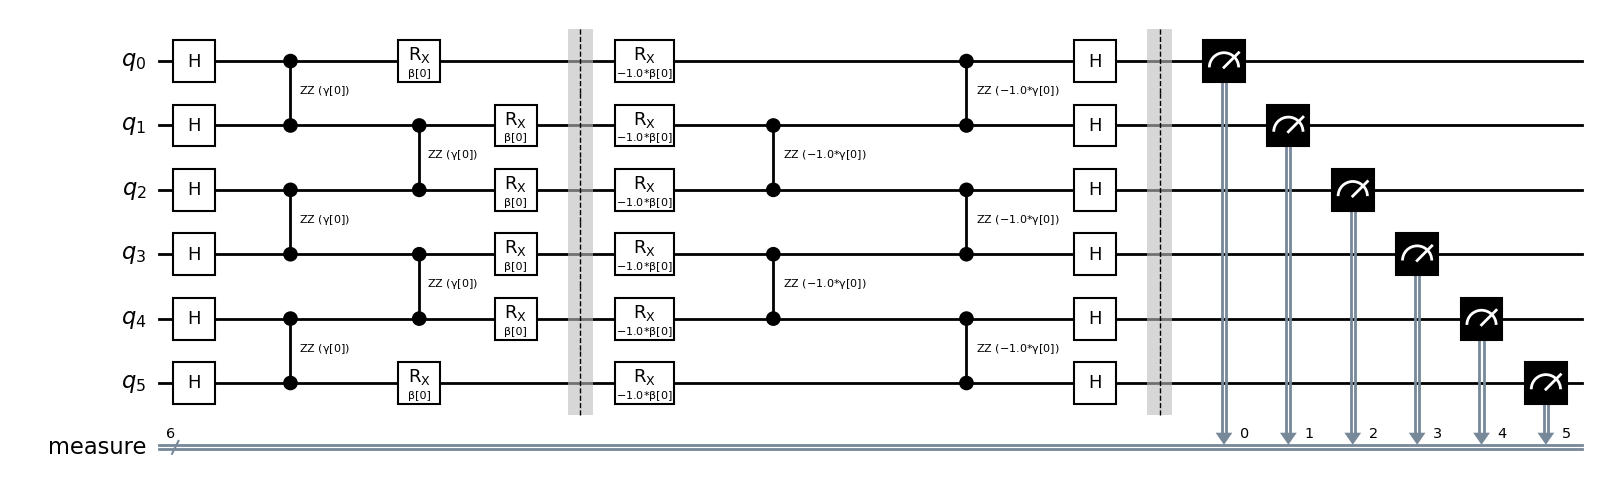

In [30]:
circ_temp = build_compute_uncompute_qaoa_circuit(6,2)
circ_temp.draw('mpl', style='bw', fold=-1)

Note that the above circuit has 10 2-qubit gates. Now we use random folding on this circuit.

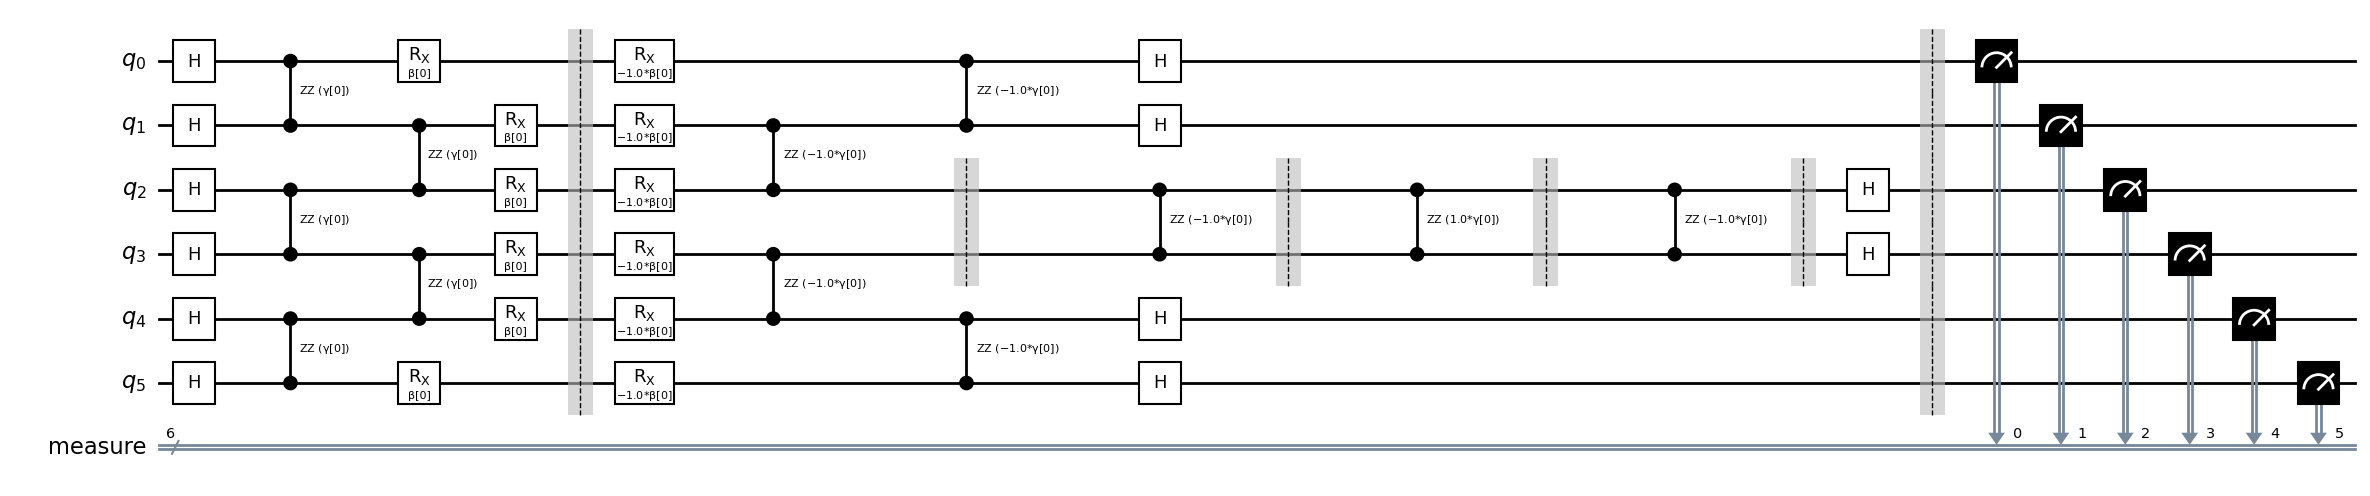

In [11]:
from zne.noise_amplification import TwoQubitAmplifier

noise_amplifier = TwoQubitAmplifier(sub_folding_option='random', random_seed=0)

amplified_circ_temp = noise_amplifier.amplify_circuit_noise(circ_temp, 1.2)
amplified_circ_temp.draw('mpl', style='bw', fold=-1)

We observe that one 2-qubit gates has been folded to create a circuit with 12 2-qubit gates. This ensures that 

<ol>
    <li>the depth of the circuit does not increase significantly due to folding</li>
    <li>hence, the increase is noise is also low, resulting in better signal</li>
    <li>since the increase in noise is low, low order extrapolator, such as linear, degree-2 polynomial etc. are sufficient for most of the scenarios</li>
</ol>

### Step 3: Execute using Qiskit Primitive

Now we shall execute using Estimator. For this, we return to our original 30 qubit QAOA circuit, and we shall set all ZNE options via Estimator only. We shall use noise factors ($\lambda$) as $\{1,1.2,1.4\}$. As discussed above, for such a folding, the increase in noise in low, and a linear extrapolator is often sufficient to approximate the zero noise expectation value.

In [12]:
estimator = Estimator(session=session)

In [42]:
estimator.options.resilience_level=2 # applies ZNE
estimator.options.resilience.zne.noise_factors=[1,1.2,1.4]
estimator.options.resilience.zne.extrapolator='linear'
estimator.options.default_shots=5000

In [43]:
params = produce_qaoa_parameters(p, seed=0)

In [44]:
job = estimator.run([(trans_qaoa, trans_obs, params)])

### Step 4: Postprocess and analyze result

We shall get the expectation value of the circuit and observable obtained using ZNE with partial folding.

In [45]:
result = job.result()[0]

In [46]:
result

PubResult(data=DataBin<>(evs=0.5315592699419873, stds=0.06250611601561394), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {'twirled_readout_errors': [[66, 0.00732421875], [67, 0.0107421875], [68, 0.0146484375], [73, 0.0205078125], [75, 0.041015625], [76, 0.03466796875], [77, 0.0205078125], [78, 0.0146484375], [85, 0.01953125], [86, 0.00830078125], [87, 0.0146484375], [90, 0.02001953125], [93, 0.00390625], [94, 0.0244140625], [95, 0.00732421875], [96, 0.07275390625], [100, 0.01953125], [101, 0.0068359375], [102, 0.015625], [103, 0.01416015625], [104, 0.015625], [105, 0.025390625], [106, 0.0048828125], [109, 0.01904296875], [110, 0.04833984375], [114, 0.0263671875], [115, 0.02099609375], [116, 0.04638671875], [117, 0.1494140625], [118, 0.02197265625]], 'zne_noise_factors': 0.0, 'zne_extrapolator': 'linear'}, 'num_randomizations': 32})

In [47]:
print(f'Expectation value with ZNE with partial folding is {result.data.evs}')

Expectation value with ZNE with partial folding is 0.5315592699419873


### Inference

We note that we obtain an extrapolated expectation value of $\sim 0.53$ using partial folding and linear extrapolation. On first look, it may seem like the expectation value is not sufficiently close to the ideal one. Therefore, we shall cross-verify the result, both without ZNE, and with ZNE using $\lambda = \{1,2,3\}$.

### Cross-verify

#### Expectation value without ZNE

First we run the same circuit without ZNE mitigation, i.e., setting the resilience_level to 0.

In [66]:
estimator.options.resilience_level=0
job_ = estimator.run([(trans_qaoa, trans_obs, params)])

In [70]:
result_ = job_.result()[0]
print(f'Expectation value without is {result_.data.evs}')

Expectation value without is 0.37334565404653514


#### Expectation value with ZNE where $\lambda = \{1,2,3\}$

Let us cross verify that using partial folding indeed provides better extrapolated expectation value than the usual ZNE folding with $\lambda \in \{1,2,3\}$. For this, we rerun the QAOA circuit with these values of $\lambda$ and obtain the extrapolated expectation value.

In [48]:
estimator.options.resilience_level=2
estimator.options.resilience.zne.noise_factors=[1,2,3]

In [49]:
non_partial_job = estimator.run([(trans_qaoa, trans_obs, params)])

In [50]:
result = non_partial_job.result()[0]
print(f'Expectation value with ZNE without partial folding is {result.data.evs}')

Expectation value with ZNE without partial folding is 0.4322624681662612


We note that the extrapolated expectation value here is worse as compared to partial folding. We can still ask the question whether using higher oder extrapolators will be helpful (note that in partial folding we used linear extrapolator only). In order to answer this, we rerun the experiment with Quadratic Extrapolator.

In [51]:
estimator.options.resilience.zne.extrapolator='polynomial_degree_2'

In [52]:
non_partial_poly_job = estimator.run([(trans_qaoa, trans_obs, params)])

In [53]:
result = non_partial_poly_job.result()[0]
print(f'Expectation value with ZNE without partial folding and quadratic extrapolator is {result.data.evs}')

Expectation value with ZNE without partial folding and quadratic extrapolator is 0.35828368467077454


We note that higher order extrapolator, in fact, provided worse expectation value. This is largely because at $\lambda = 3$, the signal coming from the circuit is mostly overcome by noise. Therefore, the extrapolation is not faithful.

This asserts that

<ol>
    <li>The obtained extrapolated expectation value via partial folding is significantly better than the extrapolated expectation value from general folding, even when the later uses higher-order extrapolators.</li>
    <li>Partial folding ensures that the decay of the expectation value with folding is within an acceptable limit, and does not die to 0 as in usual ZNE, making the extrapolation difficult.</li>
</ol>

A natural question is whether it is possible to improve the value of the expectation value to make it even closer to the ideal one. One potential method is to use measurement error mitigation, and twirling (which avoids coherent error, making the channel effectively Pauli), as shown in

*Majumdar, R., Rivero, P., Metz, F., Hasan, A., & Wang, D. S. (2023, September). Best practices for quantum error mitigation with digital zero-noise extrapolation. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 881-887). IEEE.*

Another method can be to learn the noise in the circuit, and perform the folding accordingly, as shown in

*Kim, Y., Eddins, A., Anand, S., Wei, K. X., Van Den Berg, E., Rosenblatt, S., ... & Kandala, A. (2023). Evidence for the utility of quantum computing before fault tolerance. Nature, 618(7965), 500-505.*

In [42]:
from qiskit import __version__

__version__

'1.0.2'